In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import os #we will use the function listdir to list files in a folder
import math #to apply absolute value
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

import warnings
warnings.filterwarnings('ignore')

## 01 - Problem (case study)

Goal: We want to find the next Mbappé

## 02 - Getting Data

In [2]:
data = pd.read_csv('fifa21_male2.csv')
data.head()

,ID,Name,Age,OVA,Nationality,Club,BOV,BP,Position,Player Photo,...,CDM,RDM,RWB,LB,LCB,CB,RCB,RB,GK,Gender
0,2,G. Pasquale,33,69,Italy,Udinese,71,LWB,LM,https://cdn.sofifa.com/players/000/002/16_120.png,...,70+-1,70+-1,71+-2,70+-1,69+0,69+0,69+0,70+-1,17+0,Male
1,16,Luis García,37,71,Spain,KAS Eupen,70,CM,CM CAM CDM,https://cdn.sofifa.com/players/000/016/19_120.png,...,66+1,66+1,62+1,60+1,60+1,60+1,60+1,60+1,17+1,Male
2,27,J. Cole,33,71,England,Coventry City,71,CAM,CAM RM RW LM,https://cdn.sofifa.com/players/000/027/16_120.png,...,54+0,54+0,52+0,47+0,46+0,46+0,46+0,47+0,15+0,Male
3,36,D. Yorke,36,68,Trinidad &amp; Tobago,Sunderland,70,ST,NaN,https://cdn.sofifa.com/players/000/036/09_120.png,...,65+0,65+0,56+0,57+0,51+0,51+0,51+0,57+0,22+0,Male
4,41,Iniesta,36,81,Spain,Vissel Kobe,82,CAM,CM CAM,https://cdn.sofifa.com/players/000/041/20_120.png,...,73+3,73+3,70+3,67+3,64+3,64+3,64+3,67+3,17+3,Male


## 03 - Cleaning/Wrangling

In [5]:
# Standarizing the columns
data.columns = [data.columns[i].lower().replace(' ', '_') for i in range(len(data.columns))] 

In [6]:
data = data.rename(columns={"team_&_contract": "team&contract"})

In [7]:
# Check for empty cells in the entire DataFrame
nan_cols = data.columns[data.isnull().any()]
nan_cols

Index(['club', 'position', 'club_logo', 'joined', 'loan_date_end', 'volleys',
       'curve', 'agility', 'balance', 'jumping', 'interceptions',
       'positioning', 'vision', 'composure', 'sliding_tackle', 'a/w', 'd/w'],
      dtype='object')

In [8]:
empty_cell = data['loan_date_end'].isnull().sum()
empty_cell

16215

In [9]:
# checking if column 'team&contract' can be dropped since info is in 'club' and 'contract'
selected_columns = data.loc[:, ['club', 'team&contract', 'contract']]
selected_columns

,club,team&contract,contract
0,Udinese,Udinese 2008 ~ 2016,2008 ~ 2016
1,KAS Eupen,KAS Eupen 2014 ~ 2019,2014 ~ 2019
2,Coventry City,Coventry City 2016 ~ 2020,2016 ~ 2020
3,Sunderland,Sunderland 2009,2009
4,Vissel Kobe,Vissel Kobe 2018 ~ 2021,2018 ~ 2021
...,...,...,...
17120,CD Tondela,"CD Tondela Jun 30, 2021 On Loan","Jun 30, 2021 On Loan"
17121,Burnley,Burnley 2020 ~ 2021,2020 ~ 2021
17122,Burnley,Burnley 2020 ~ 2022,2020 ~ 2022
17123,SK Sturm Graz,SK Sturm Graz 2020 ~ 2023,2020 ~ 2023


In [10]:
# Get rid of several columns
data = data.drop(columns=["player_photo", "club_logo", "flag_photo", "team&contract", "gender", "loan_date_end"])

In [11]:
# Check if "id" has duplicated values
if data['id'].duplicated().any():
    print("There are duplicate values in 'id'.")
else:
    print("All values in 'id' are unique.")


All values in 'id' are unique.


In [12]:
data = data.set_index('id') # id is unique, so I passed it as the index

In [13]:
data.head()

,name,age,ova,nationality,club,bov,bp,position,pot,height,...,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb,gk
id,,,,,,,,,,,,,,,,,,,,,
2,G. Pasquale,33,69,Italy,Udinese,71,LWB,LM,69,"6'0""",...,70+-1,70+-1,70+-1,71+-2,70+-1,69+0,69+0,69+0,70+-1,17+0
16,Luis García,37,71,Spain,KAS Eupen,70,CM,CM CAM CDM,71,"5'10""",...,66+1,66+1,66+1,62+1,60+1,60+1,60+1,60+1,60+1,17+1
27,J. Cole,33,71,England,Coventry City,71,CAM,CAM RM RW LM,71,"5'9""",...,54+0,54+0,54+0,52+0,47+0,46+0,46+0,46+0,47+0,15+0
36,D. Yorke,36,68,Trinidad &amp; Tobago,Sunderland,70,ST,NaN,82,"5'11""",...,65+0,65+0,65+0,56+0,57+0,51+0,51+0,51+0,57+0,22+0
41,Iniesta,36,81,Spain,Vissel Kobe,82,CAM,CM CAM,81,"5'7""",...,73+3,73+3,73+3,70+3,67+3,64+3,64+3,64+3,67+3,17+3


In [14]:
# function to convert value to unified format
def convert_value(value):
    if isinstance(value, float):
        return value
    elif value.endswith('K'):
        return float(value[1:-1]) * 1000
    elif value.endswith('M'):
        return float(value[1:-1]) * 1000000
    else:
        try:
            return float(value)
        except ValueError:
            return None

# apply function to value column
data['value'] = data['value'].apply(convert_value)

data.head()

,name,age,ova,nationality,club,bov,bp,position,pot,height,...,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb,gk
id,,,,,,,,,,,,,,,,,,,,,
2,G. Pasquale,33,69,Italy,Udinese,71,LWB,LM,69,"6'0""",...,70+-1,70+-1,70+-1,71+-2,70+-1,69+0,69+0,69+0,70+-1,17+0
16,Luis García,37,71,Spain,KAS Eupen,70,CM,CM CAM CDM,71,"5'10""",...,66+1,66+1,66+1,62+1,60+1,60+1,60+1,60+1,60+1,17+1
27,J. Cole,33,71,England,Coventry City,71,CAM,CAM RM RW LM,71,"5'9""",...,54+0,54+0,54+0,52+0,47+0,46+0,46+0,46+0,47+0,15+0
36,D. Yorke,36,68,Trinidad &amp; Tobago,Sunderland,70,ST,NaN,82,"5'11""",...,65+0,65+0,65+0,56+0,57+0,51+0,51+0,51+0,57+0,22+0
41,Iniesta,36,81,Spain,Vissel Kobe,82,CAM,CM CAM,81,"5'7""",...,73+3,73+3,73+3,70+3,67+3,64+3,64+3,64+3,67+3,17+3


In [15]:
# Check the data type of the 'value' column
data['value'].dtype

dtype('float64')

In [16]:
empty_cell2 = data['value'].isnull().sum()
empty_cell2

457

In [17]:
# Select the rows with missing values in the 'value' column
missing_values = data[data['value'].isnull()]
missing_values

,name,age,ova,nationality,club,bov,bp,position,pot,height,...,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb,gk
id,,,,,,,,,,,,,,,,,,,,,
36,D. Yorke,36,68,Trinidad &amp; Tobago,Sunderland,70,ST,NaN,82,"5'11""",...,65+0,65+0,65+0,56+0,57+0,51+0,51+0,51+0,57+0,22+0
244,G. Neville B,35,76,England,Manchester United,78,CB,RB CB RWB,82,"5'10""",...,74+0,74+0,74+0,73+0,76+0,78+0,78+0,78+0,76+0,13+0
250,D. Beckham,37,78,England,NaN,77,CM,CM RM,78,"6'0""",...,73+1,73+1,73+1,67+1,63+1,59+1,59+1,59+1,63+1,15+1
388,S. Campbell,35,75,England,Newcastle United,75,CB,NaN,79,"6'2""",...,68+0,68+0,68+0,63+0,70+0,75+0,75+0,75+0,70+0,12+0
488,O. Kahn,38,87,Germany,FC Bayern München,87,GK,GK,90,"6'2""",...,31+0,31+0,31+0,29+0,31+0,31+0,31+0,31+0,31+0,87+0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
258452,T. Cseri,32,67,Hungary,Hungary,67,RW,RW LW,67,"5'9""",...,47+2,47+2,47+2,52+2,48+2,37+2,37+2,37+2,48+2,17+2
258453,B. Babati,24,63,Hungary,Hungary,64,LM,RM ST,69,"5'9""",...,42+2,42+2,42+2,48+2,44+2,34+2,34+2,34+2,44+2,15+2
258500,F. Krastev,18,58,Bulgaria,Bulgaria,60,CAM,CAM CM,75,"5'8""",...,49+2,49+2,49+2,51+2,48+2,40+2,40+2,40+2,48+2,15+2


In [18]:
# Create a new dataset without the rows with empty cells in "value" column
# data2 = data.dropna(subset=['value'])
# data2

### Encoding

In [19]:
# Convert height data from feet and inches to centimeters
data['height_cm'] = data['height'].apply(lambda x: int(x.split("'")[0])*30.48 + int(x.split("'")[1].replace('"', ''))*2.54)
data['height_cm']

# Drop the original 'height' column
data.drop('height', axis=1, inplace=True)

id
2         182.88
16        177.80
27        175.26
36        180.34
41        170.18
           ...  
259088    198.12
259090    177.80
259091    175.26
259101    175.26
259105    177.80
Name: height_cm, Length: 17125, dtype: float64

In [21]:
# Convert weight data from pounds to kilograms
data['weight_kg'] = data['weight'].apply(lambda x: int(x[:-3]) / 2.2046)
data['weight_kg']

# Drop the original 'weight' column
data.drop('weight', axis=1, inplace=True)

In [22]:
# Convert wage and release_clause data to numeric value
data['wage'] = data['wage'].apply(convert_value)
data['release_clause'] = data['release_clause'].apply(convert_value)
data['wage']

id
2          7000.0
16         7000.0
27        15000.0
36            NaN
41        12000.0
           ...   
259088     2000.0
259090     3000.0
259091     2000.0
259101     3000.0
259105     2000.0
Name: wage, Length: 17125, dtype: float64

In [23]:
data['release_clause']

id
2               NaN
16        1100000.0
27              NaN
36              NaN
41        7200000.0
            ...    
259088          NaN
259090     273000.0
259091     273000.0
259101     784000.0
259105     788000.0
Name: release_clause, Length: 17125, dtype: float64

In [24]:
# Apply lambda function to 'w/f' column
data['w/f_encoded'] = data['w/f'].apply(lambda x: int(x[0]))
data['w/f_encoded']

# Drop the original 'w/f' column
data.drop('w/f', axis=1, inplace=True)

In [25]:
# Apply lambda function to 'w/f' column
data['sm_encoded'] = data['sm'].apply(lambda x: int(x[0]))
data['sm_encoded']

# Drop the original 'sm' column
data.drop('sm', axis=1, inplace=True)

In [26]:
# Apply lambda function to 'w/f' column
data['ir_encoded'] = data['ir'].apply(lambda x: int(x[0]))
data['ir_encoded']

# Drop the original 'sm' column
data.drop('ir', axis=1, inplace=True)

In [27]:
# Initialize the LabelEncoder object
le = LabelEncoder()

# Fit and transform the data frame column
data['a/w_encoded'] = le.fit_transform(data['a/w'])
data['d/w_encoded'] = le.fit_transform(data['d/w'])

# Drop the original 'a/w' and 'd/w' column
# data.drop('a/w', axis=1, inplace=True)
# data.drop('d/w', axis=1, inplace=True)

In [28]:
# Modify cells with 'K' character, leave others unchanged, turn it to integer
data['hits'] = data['hits'].apply(lambda x: float(x.replace('K','')) * 1000 if isinstance(x, str) and 'K' in x else x).astype(int)

In [29]:
data['hits'].unique()

array([   4,   11,    3,  149,    7,    9,   16,   10,    5,    8,  154,
          6,   18,   22,   34,   19,   15,   14,   27,   21,  309,   32,
        151,  750,   13,   39,   83,   20,  442,   92,   23,   29,   30,
         12,   31,  297,   36,   90,   88,   24,  171,   40,   25,   60,
        103,   38,   82,   57,   17,   26,   44,   67,  571,   61,   68,
         37,  231,   58,   62,   28,   51,   45,   80,  162,   59,  138,
        220,   93,   47,  281,   33,   46,   35,  830,   43,   64,   49,
         48,   54,  259,  161,   74,  434,   42,  131,  222,  229,  125,
        142,   81,  128,   78,  109,   72,   75,  111,   63,  123,  136,
         89,   55,  663,   97,   41,  143,   73,  464,  232,  164,  212,
        129,   79,  107,   69,  117,   71,  101,  202,  140,  110,   66,
       6300,  122,   95,  189,  157,  215,   52,  248,  178,  238,  208,
        214,  407, 1200,  349,  180,  224,  155,  147,   98,   99,  152,
        148,  120,  167,  158,   70,  328,  183,   

In [31]:
# Create a new dataframe with only the numerical columns using select_dtypes
numericals = data.select_dtypes(np.number).apply(lambda x: round(x,2))
numericals.head()

,age,ova,bov,pot,growth,value,wage,release_clause,attacking,crossing,...,def,phy,hits,height_cm,weight_kg,w/f_encoded,sm_encoded,ir_encoded,a/w_Encoded,d/w_Encoded
id,,,,,,,,,,,,,,,,,,,,,
2,33,69,71,69,0,625000.0,7000.0,NaN,313,75,...,68,69,4,182.88,82.10,3,2,2,2,0
16,37,71,70,71,0,600000.0,7000.0,1100000.0,337,68,...,58,63,4,177.80,64.86,4,3,1,2,2
27,33,71,71,71,0,1100000.0,15000.0,NaN,337,80,...,36,52,11,175.26,73.03,4,4,2,2,1
36,36,68,70,82,14,NaN,NaN,NaN,264,54,...,47,60,3,180.34,74.84,3,1,1,3,3
41,36,81,82,81,0,5500000.0,12000.0,7200000.0,367,75,...,63,59,149,170.18,68.04,4,4,4,0,2


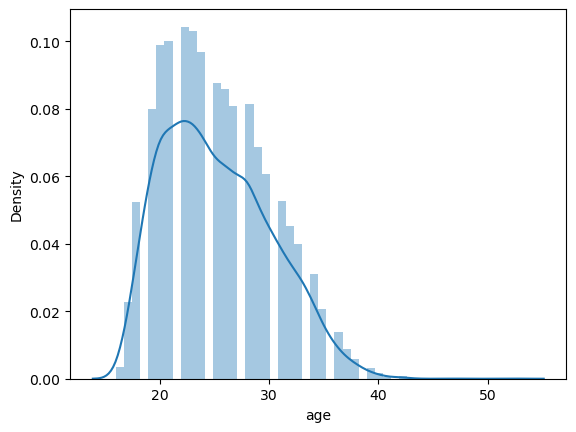

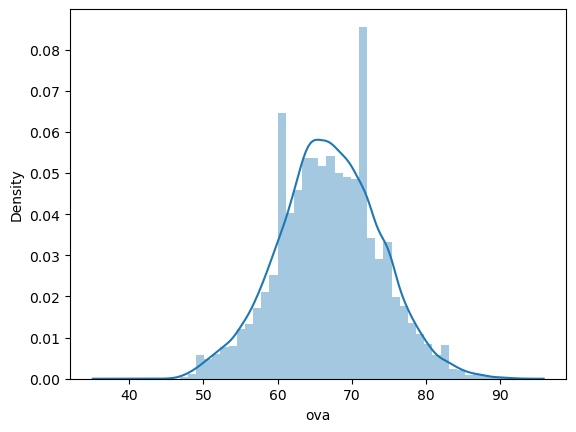

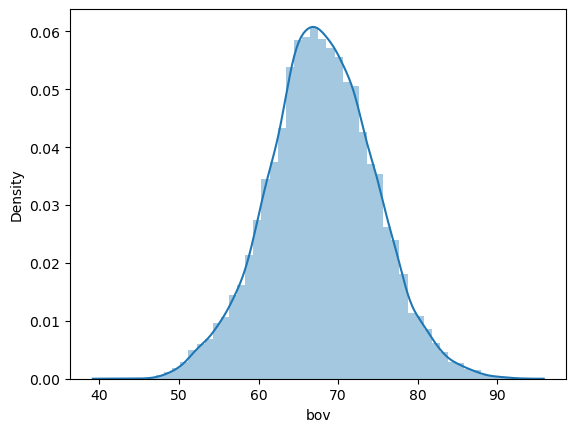

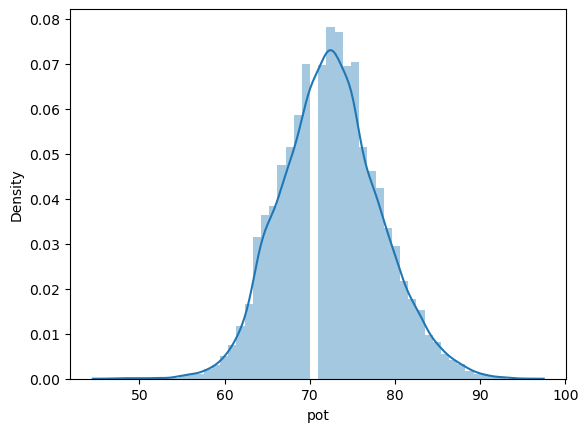

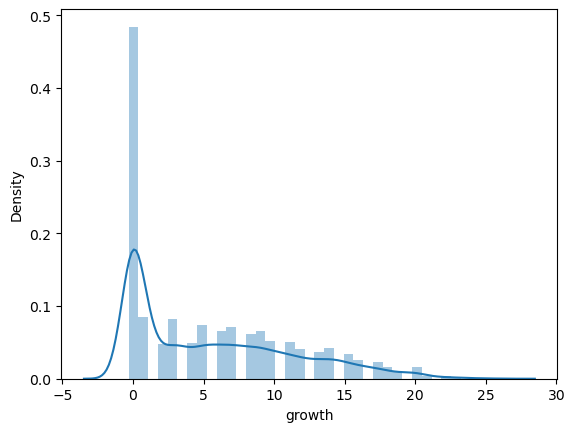

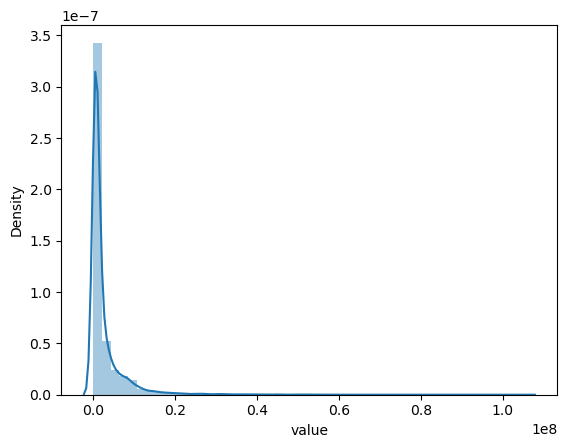

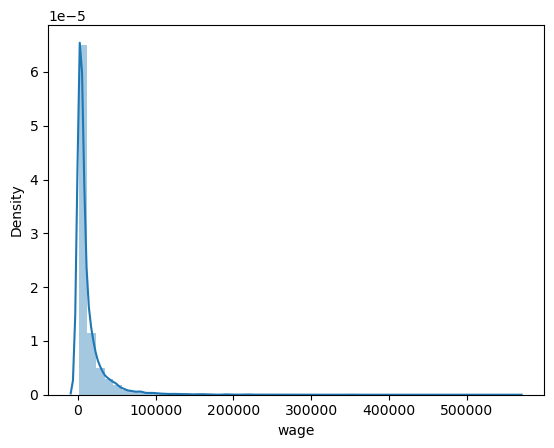

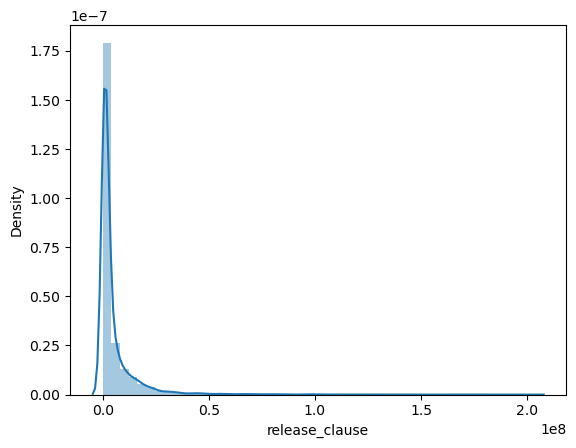

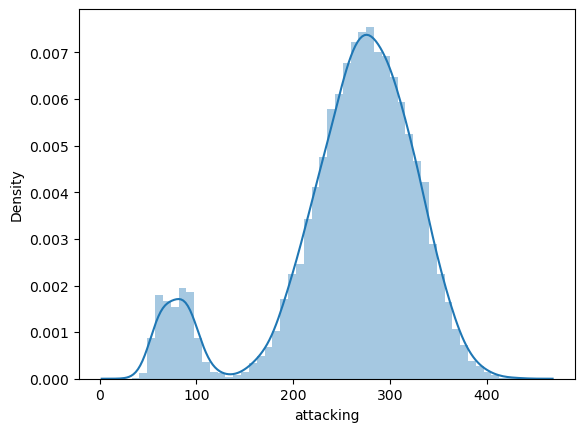

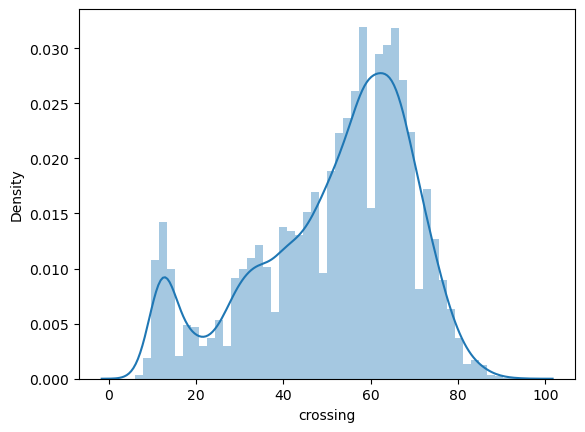

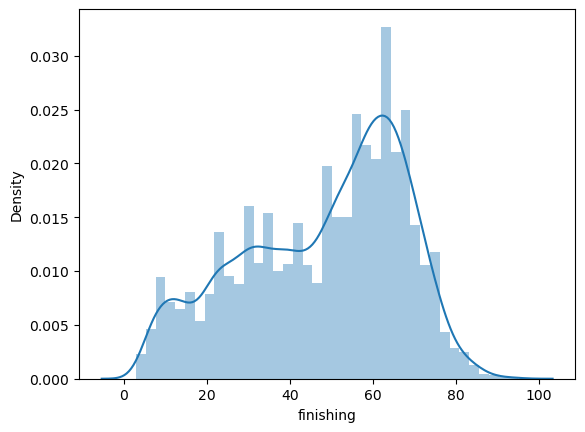

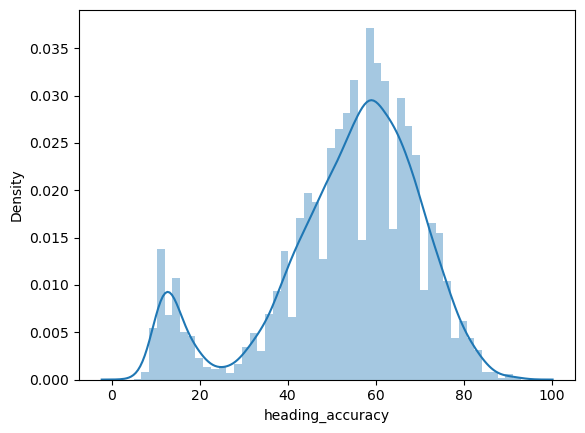

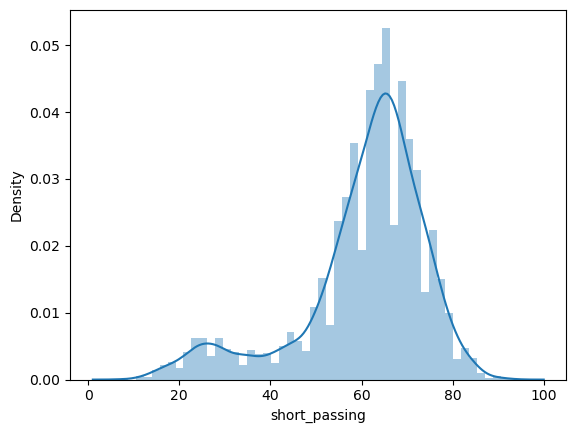

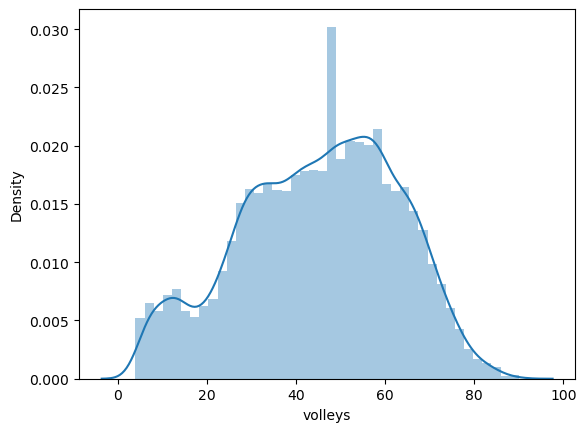

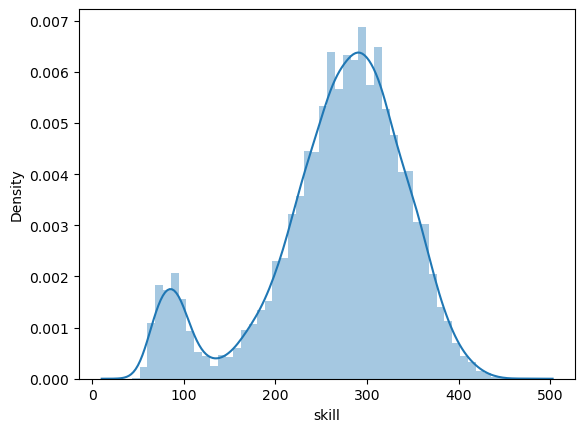

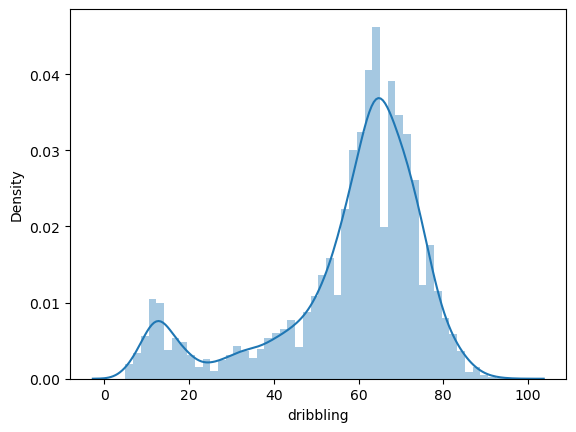

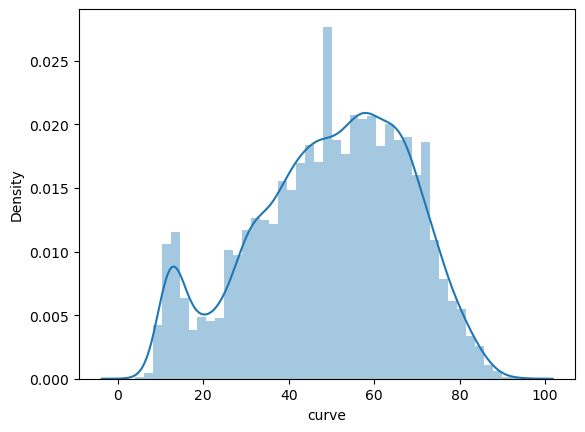

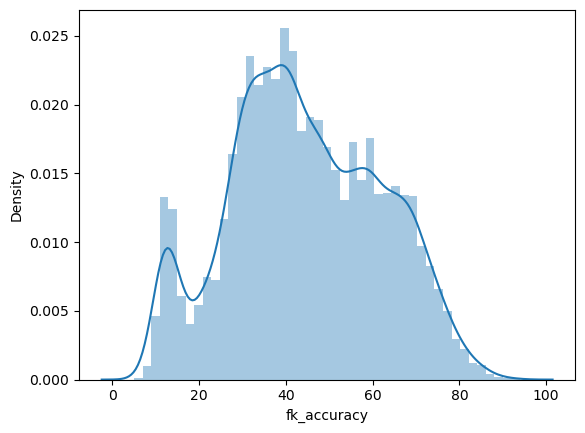

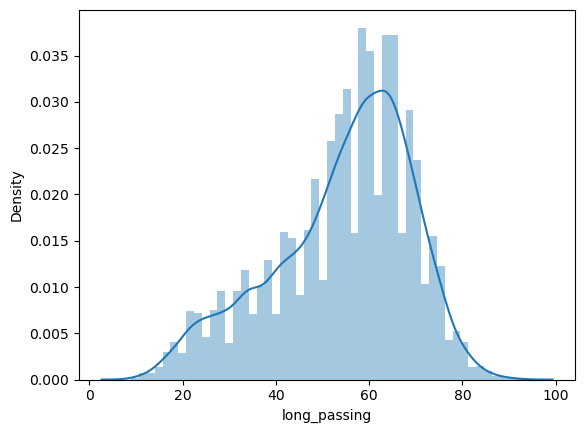

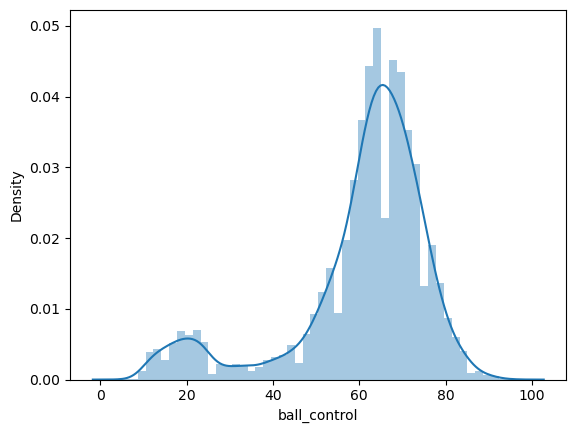

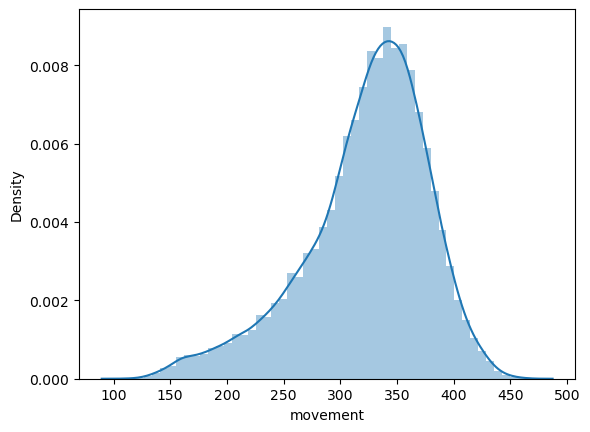

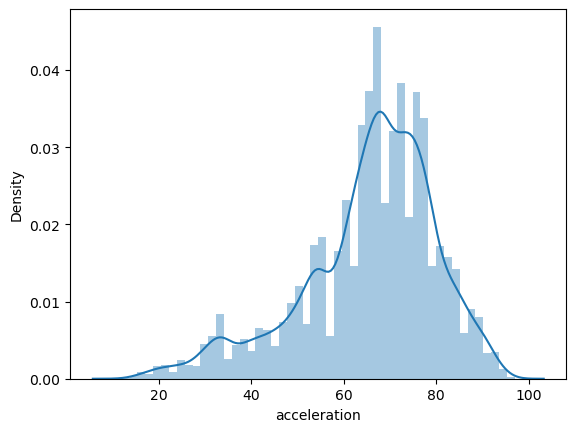

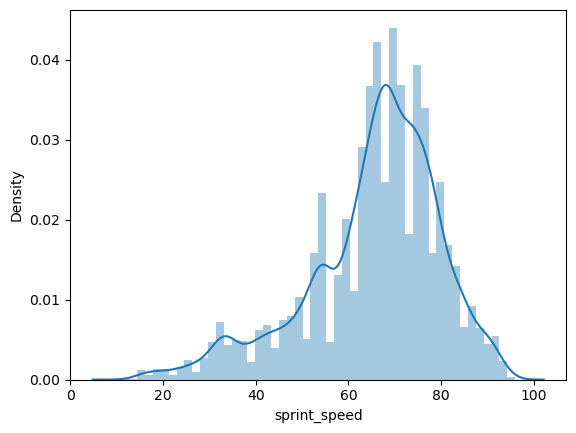

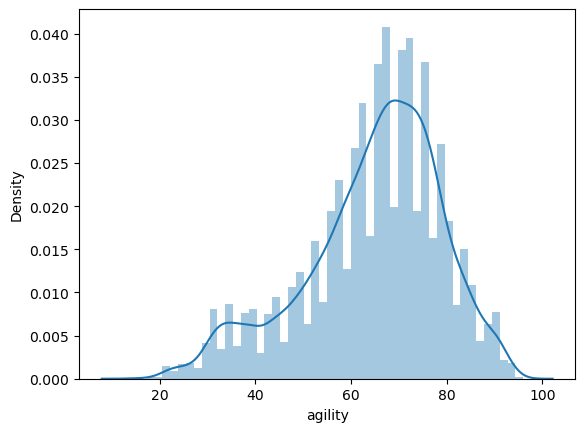

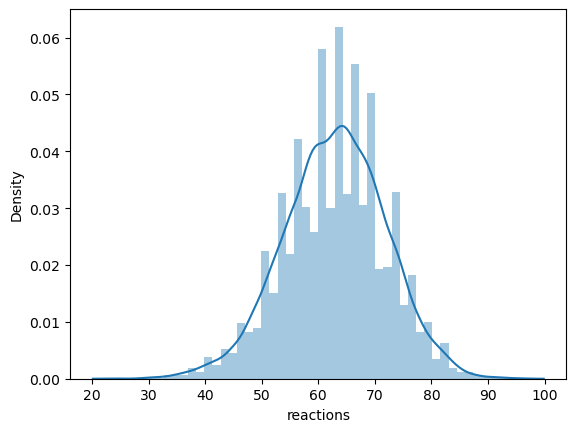

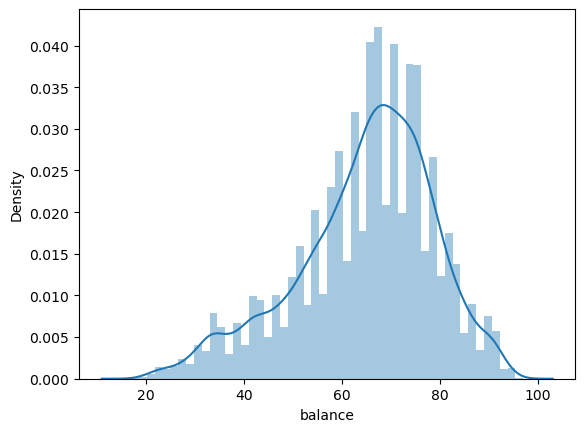

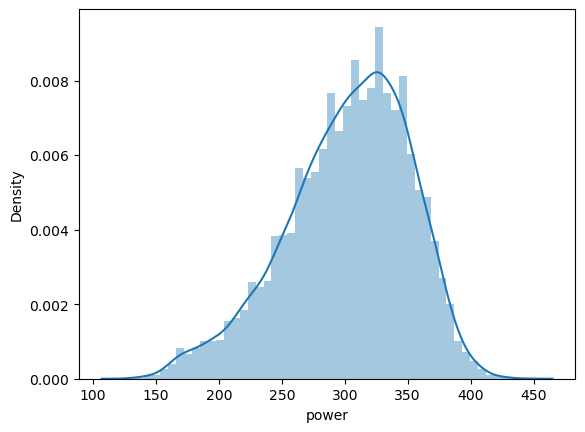

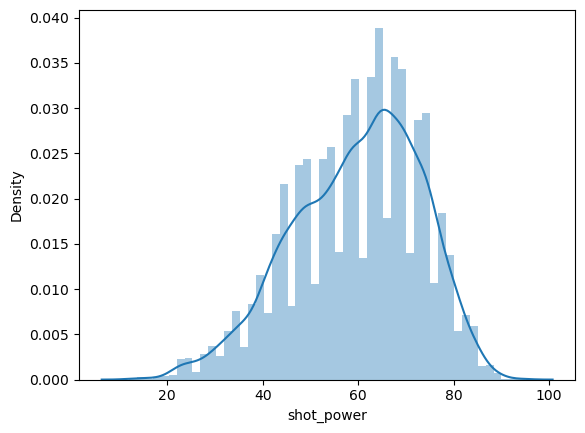

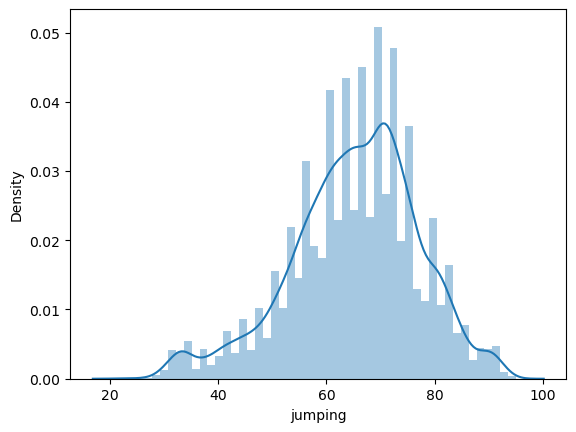

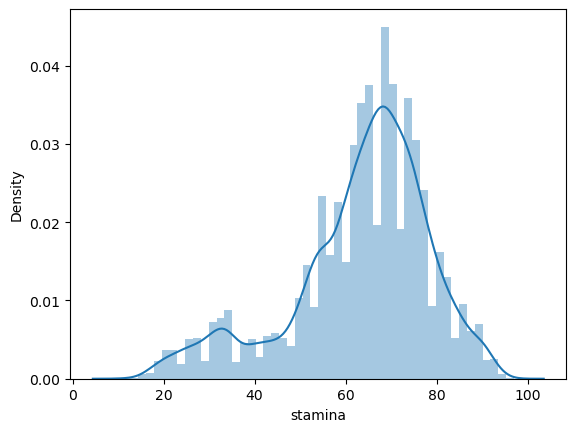

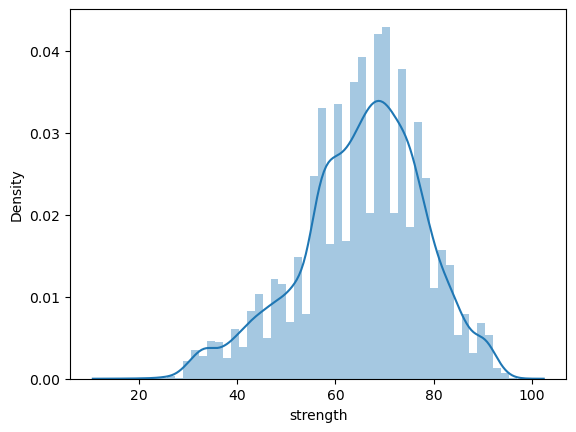

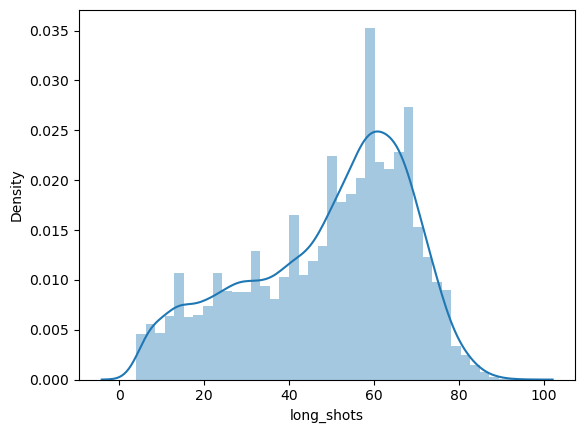

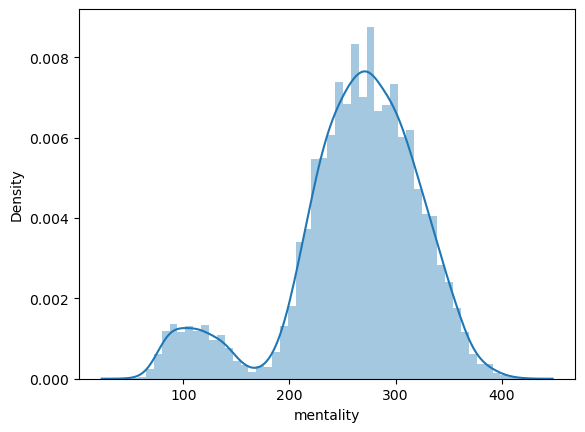

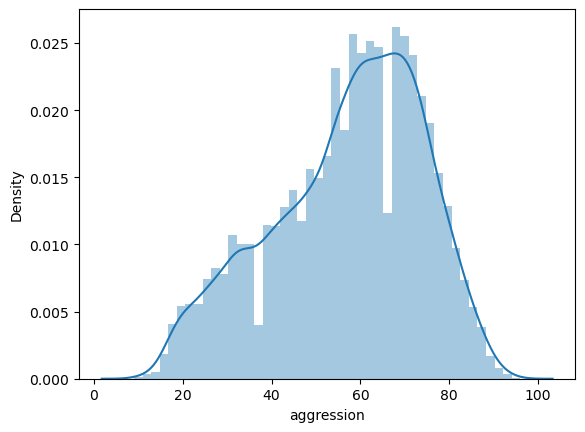

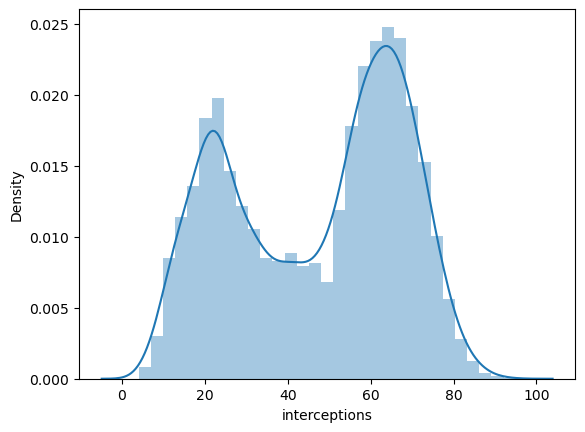

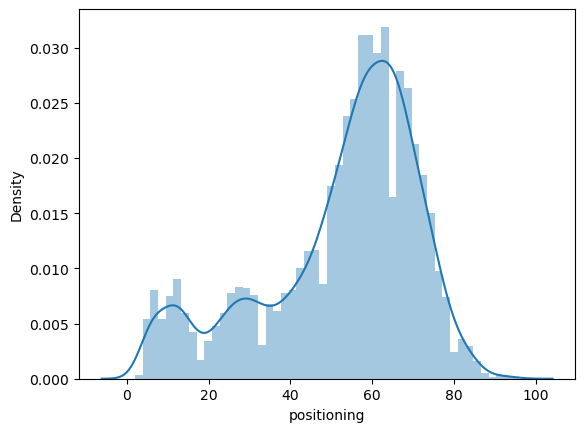

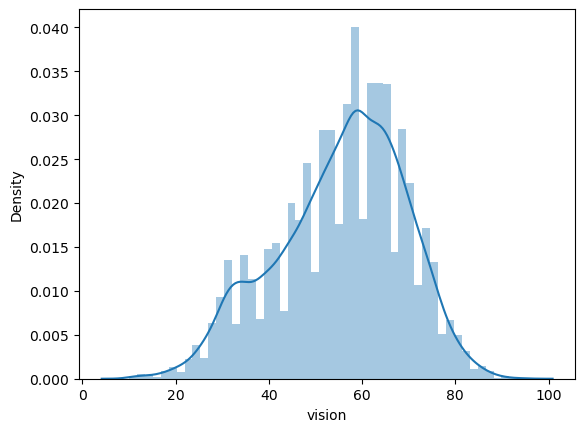

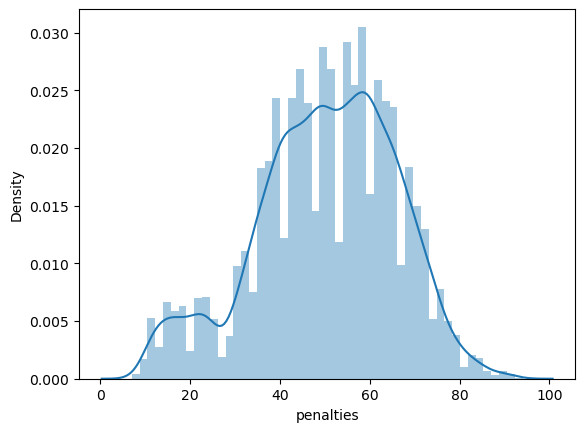

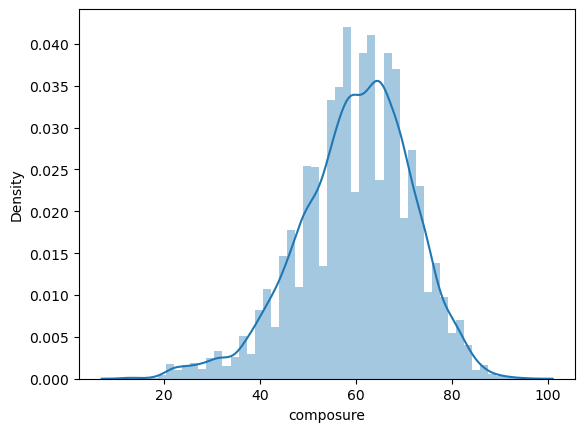

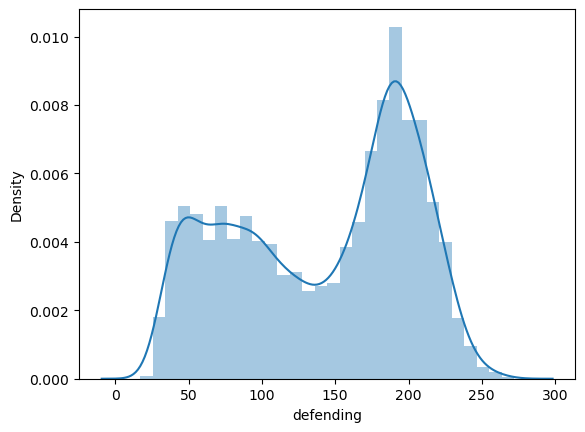

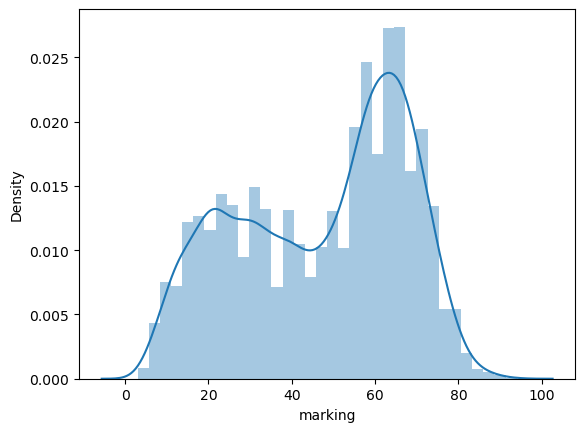

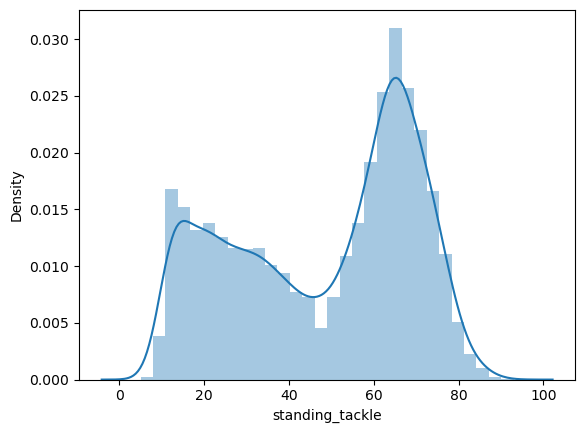

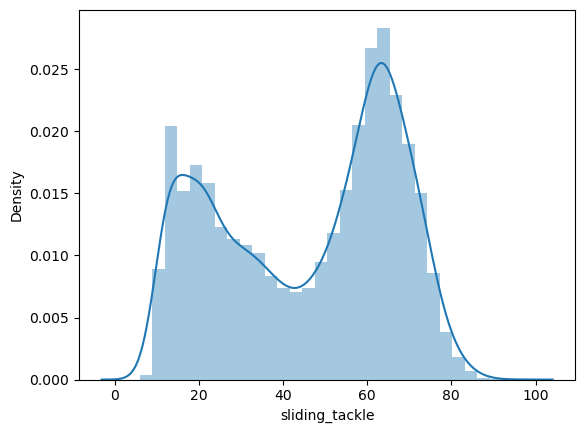

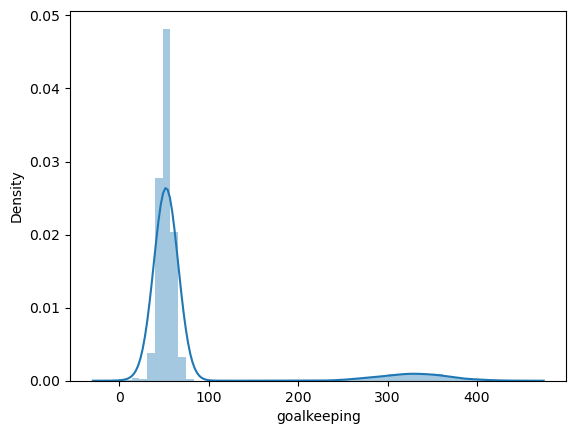

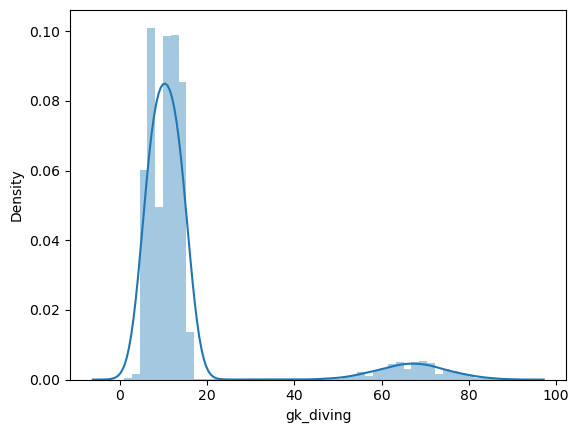

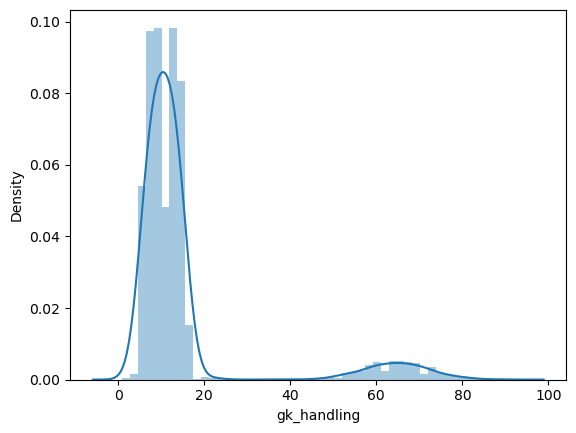

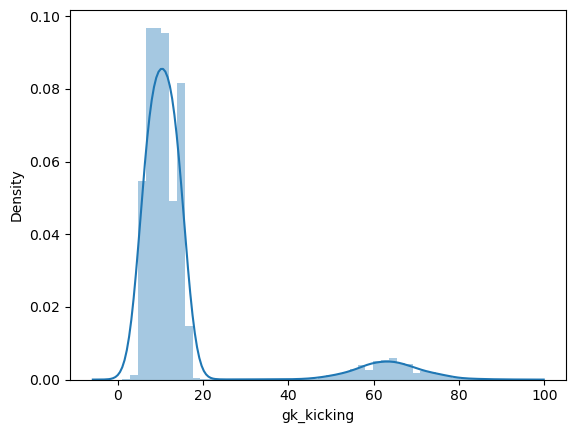

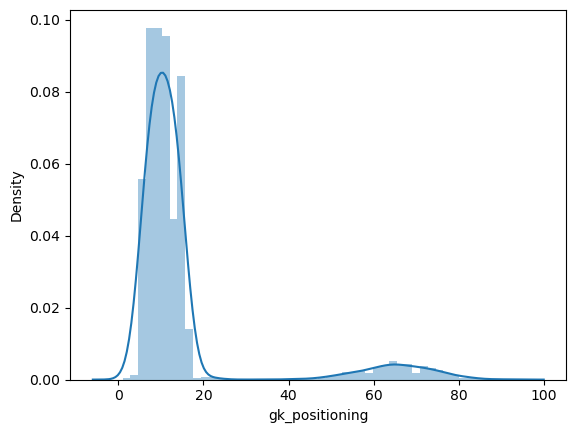

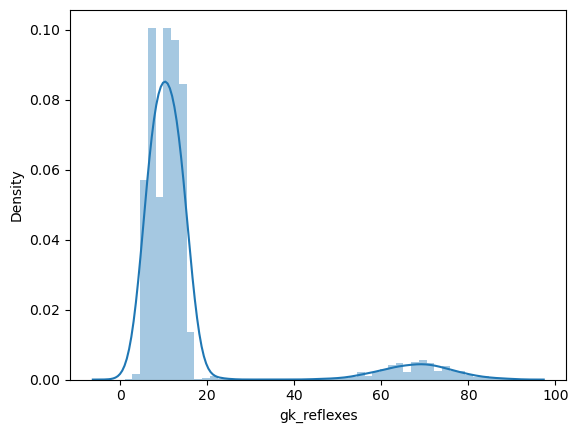

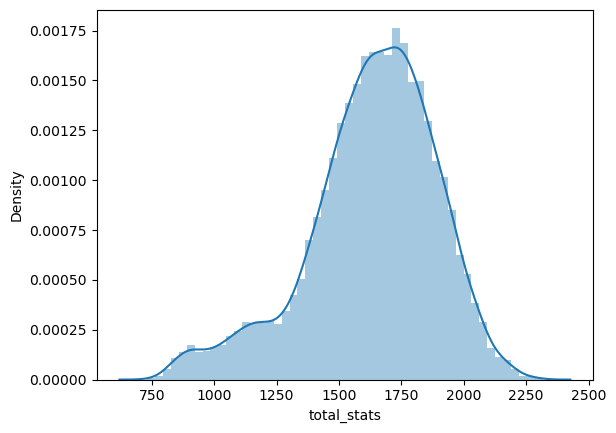

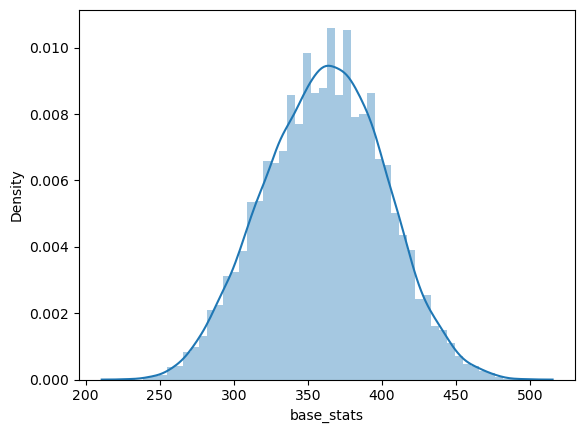

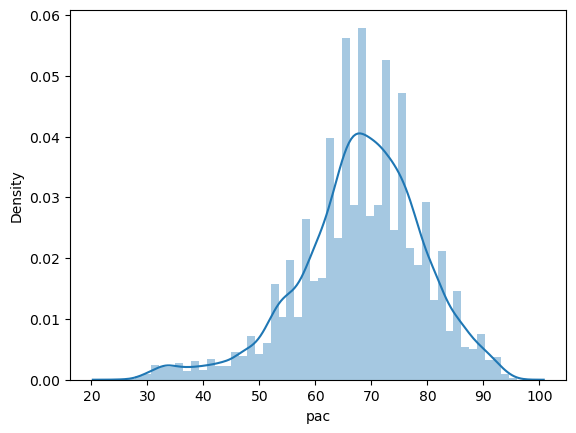

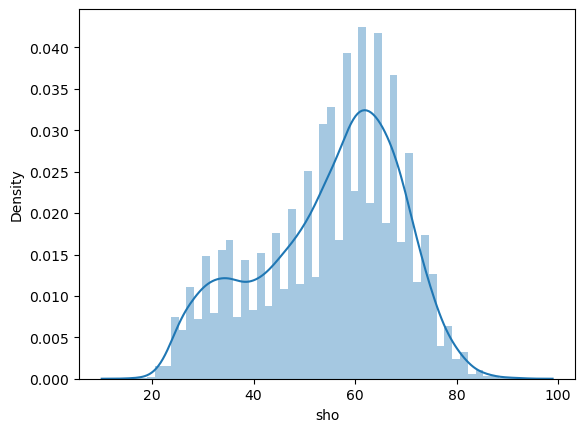

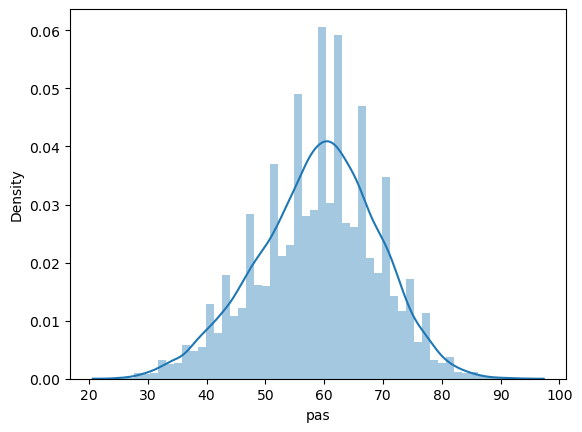

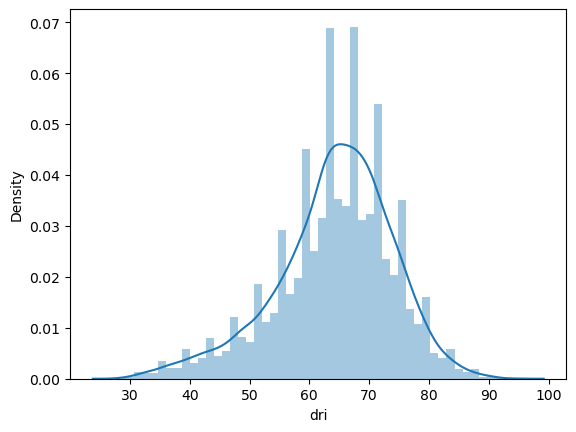

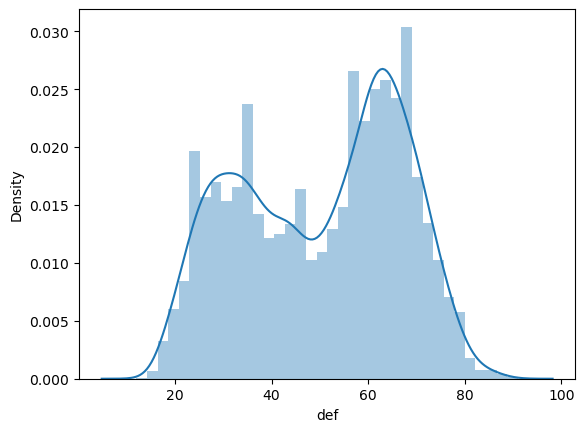

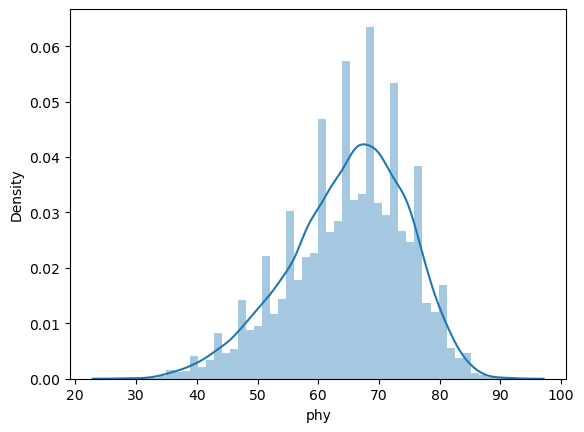

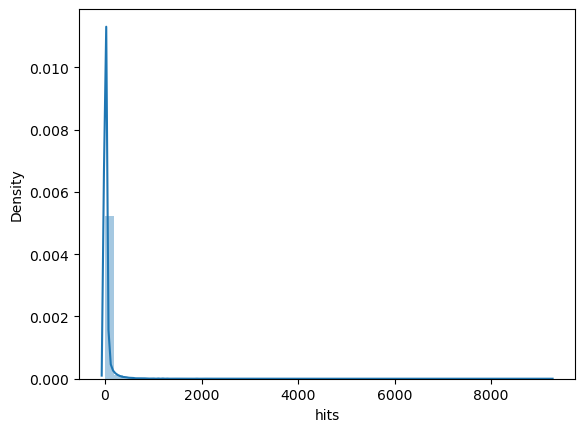

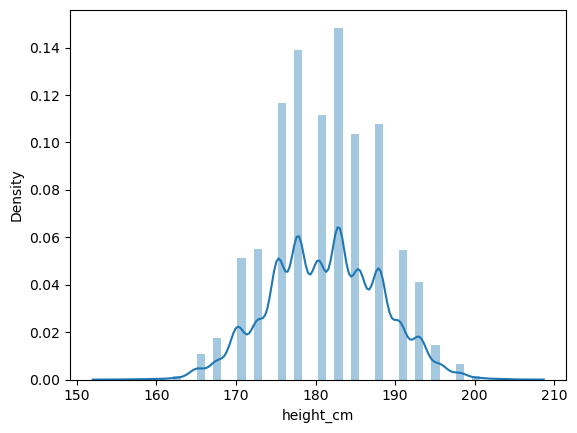

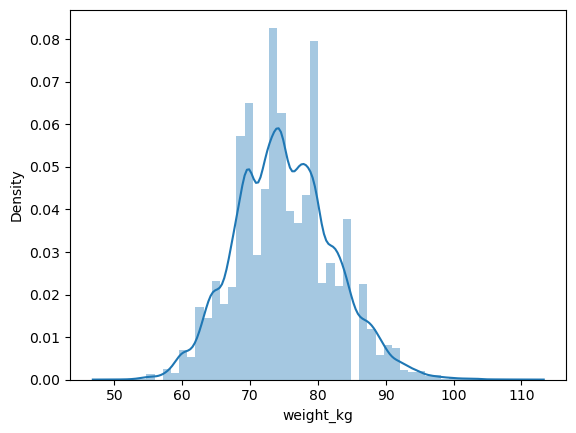

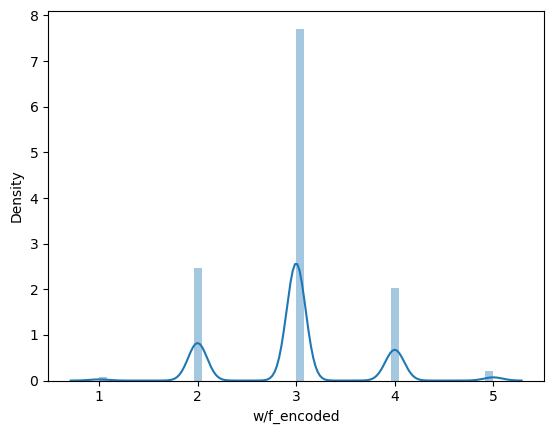

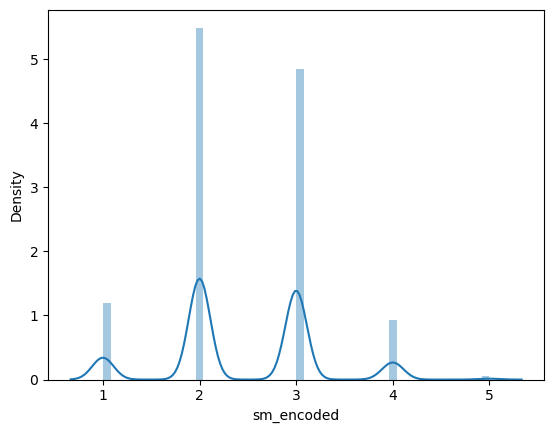

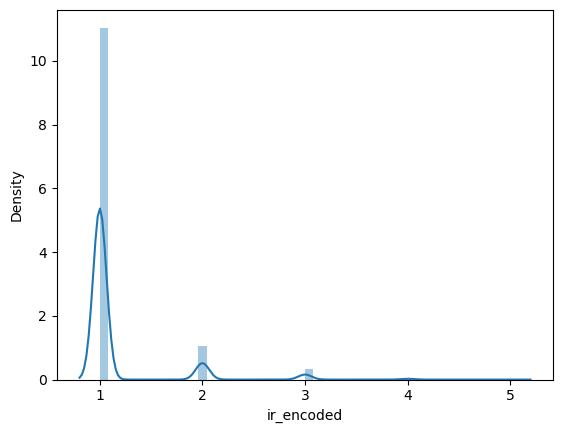

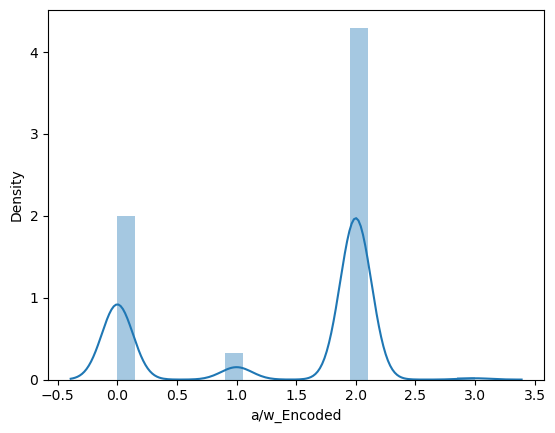

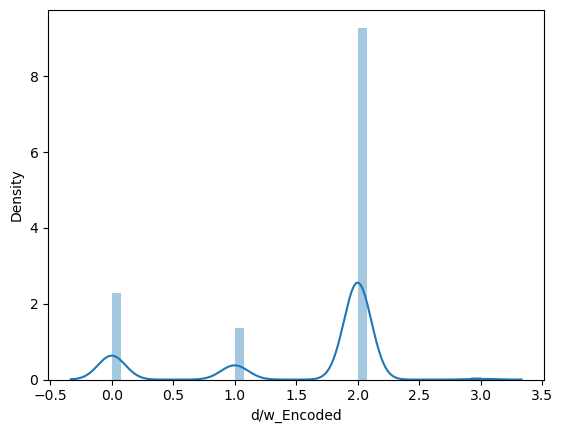

In [32]:
for column in numericals.columns:
    sns.distplot(data[column])
    plt.show()

In [33]:
# Create a new dataframe with only the categorical columns using select_dtypes
categoricals = data.select_dtypes(include = np.object)
categoricals.head()

,name,nationality,club,bp,position,foot,joined,contract,a/w,d/w,...,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb,gk
id,,,,,,,,,,,,,,,,,,,,,
2,G. Pasquale,Italy,Udinese,LWB,LM,Left,"Jul 1, 2008",2008 ~ 2016,Medium,High,...,70+-1,70+-1,70+-1,71+-2,70+-1,69+0,69+0,69+0,70+-1,17+0
16,Luis García,Spain,KAS Eupen,CM,CM CAM CDM,Right,"Jul 19, 2014",2014 ~ 2019,Medium,Medium,...,66+1,66+1,66+1,62+1,60+1,60+1,60+1,60+1,60+1,17+1
27,J. Cole,England,Coventry City,CAM,CAM RM RW LM,Right,"Jan 7, 2016",2016 ~ 2020,Medium,Low,...,54+0,54+0,54+0,52+0,47+0,46+0,46+0,46+0,47+0,15+0
36,D. Yorke,Trinidad &amp; Tobago,Sunderland,ST,NaN,Right,NaN,2009,NaN,NaN,...,65+0,65+0,65+0,56+0,57+0,51+0,51+0,51+0,57+0,22+0
41,Iniesta,Spain,Vissel Kobe,CAM,CM CAM,Right,"Jul 16, 2018",2018 ~ 2021,High,Medium,...,73+3,73+3,73+3,70+3,67+3,64+3,64+3,64+3,67+3,17+3


In [34]:
for var in categoricals:
    counts = categoricals[var].value_counts()
    print("Counts for variable {}: \n{}".format(var, counts))

Counts for variable name: 
J. Rodríguez       10
A. Traoré           8
J. Rojas            8
J. Jones            7
Paulinho            7
                   ..
F. Ondoa            1
K. Opare            1
T. Abe              1
N. Stark            1
Pablo Rodríguez     1
Name: name, Length: 16176, dtype: int64
Counts for variable nationality: 
England      1707
Germany      1154
Spain        1121
France        990
Brazil        857
             ... 
Tanzania        1
Singapore       1
Eritrea         1
Malta           1
Barbados        1
Name: nationality, Length: 167, dtype: int64
Counts for variable club: 
Chelsea                         45
Manchester United               45
Bolton Wanderers                45
Wolverhampton Wanderers         43
AS Monaco                       43
                                ..
Vitória                          1
CA Bastia                        1
Inverness Caledonian Thistle     1
Denmark                          1
Galway United                    1
Na

## 04 - Exploratory Data Analysis

In [35]:
# Looking at promising talents

In [36]:
data['pot_minus_ova'] = data['pot'] - data['ova'] 

In [37]:
# Create a new DataFrame that contains only the rows with "difference" > 10 and age < 21
talents = data[(data['pot_minus_ova'] > 10) & (data['age'] < 21)]
talents.head()

,name,age,ova,nationality,club,bov,bp,position,pot,foot,...,rb,gk,height_cm,weight_kg,w/f_encoded,sm_encoded,ir_encoded,a/w_Encoded,d/w_Encoded,pot_minus_ova
id,,,,,,,,,,,,,,,,,,,,,
177561,B. Rodriguez,20,50,Uruguay,River Plate,50,ST,ST,66,Right,...,34+0,10+0,187.96,79.833076,2,1,1,3,3,16
183303,Vasconcelos,19,57,Brazil,América de Natal,57,CM,CM,71,Right,...,51+0,23+0,182.88,81.193867,3,1,1,3,3,14
184384,D. Stadelmann,20,42,Switzerland,FC Lausanne-Sport,48,RM,RM,62,Right,...,37+0,20+0,180.34,73.029121,3,1,1,3,3,20
188790,S. Mehamha,19,57,France,Olympique Lyonnais,57,CDM,CDM CM,76,Right,...,56+0,13+0,170.18,64.864374,3,2,1,3,3,19
201391,A. Romanò,19,57,Italy,Crotone,59,RM,CM CAM,77,Right,...,49+0,13+0,182.88,74.843509,3,2,1,2,2,20


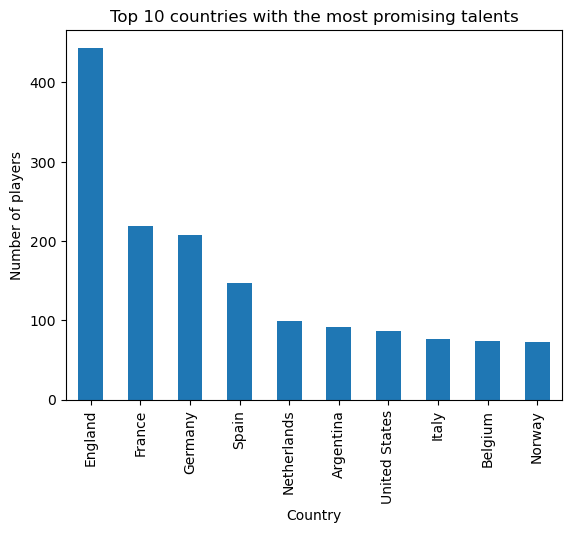

In [38]:
# Group the data by country and count the number of players in each country
talents_by_country = talents.groupby('nationality')['name'].count().sort_values(ascending=False)

# Plot a bar chart of the top 10 countries with the most players
talents_by_country.head(10).plot(kind='bar')

# Add labels and a title to the chart
plt.xlabel('Country')
plt.ylabel('Number of players')
plt.title('Top 10 countries with the most promising talents')

# Display the chart
plt.show()


In [39]:
# Looking at MVPs with rating >80

In [40]:
mvps = data[(data['ova'] > 80)]

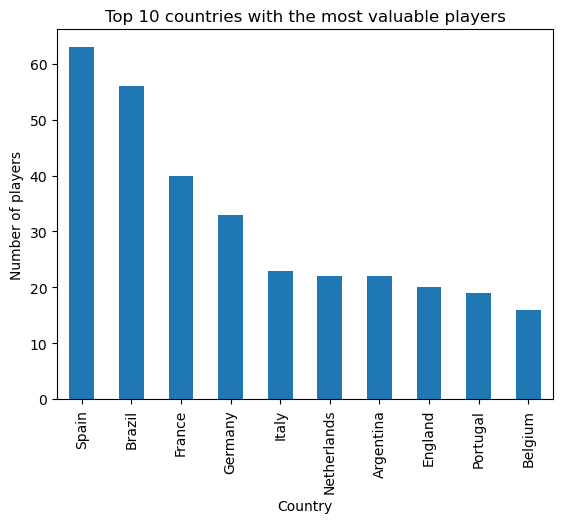

In [41]:
# Group the data by country and count the number of players in each country
mvps_by_country = mvps.groupby('nationality')['name'].count().sort_values(ascending=False)

# Plot a bar chart of the top 10 countries with the most players
mvps_by_country.head(10).plot(kind='bar')

# Add labels and a title to the chart
plt.xlabel('Country')
plt.ylabel('Number of players')
plt.title('Top 10 countries with the most valuable players')

# Display the chart
plt.show()


## 05 - Processing Data

## 06 - Modeling

## 07 - Model Validation